<a href="https://www.kaggle.com/code/yti1412/fraudulent-transaction-detection?scriptVersionId=181672748" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraudulent-transactions-data/Fraud.csv


### My aim is to predict fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.
### **Aurthor** : *Yati Maheshwari*

## Importing the relevant libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('/kaggle/input/fraudulent-transactions-data/Fraud.csv')
df = data.copy()
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.tail(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


**Data Definition**


* **step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* **amount**: amount of the transaction in local currency.

* **nameOrig**: customer who started the transaction

* **oldbalanceOrg**: initial balance before the transaction

* **newbalanceOrig**: new balance after the transaction

* **nameDest**: customer who is the recipient of the transaction

* **oldbalanceDest**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* **newbalanceDest**: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* **isFraud**: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* **isFlaggedFraud**: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


**We noticed that there is a large volume of data to be analyzed, 
with over 6.3 million rows divided into 1 dependent variable (isFraud) 
and 10 independent variables that characterize the transactions.**

In [5]:
def check_fraud_merchant():
    new_df = df[df['nameDest'].str.startswith('M')]
    return [new_df['isFraud'].sum(),new_df['type'].unique(),new_df['oldbalanceDest'].sum(),new_df['newbalanceDest'].sum(),new_df.shape,new_df['isFlaggedFraud'].sum()]
check_fraud_merchant()

[0, array(['PAYMENT'], dtype=object), 0.0, 0.0, (2151495, 11), 0]

**For Merchants there is no information regarding the attribute oldbalanceDest and newbalanceDest.<br>
So we can clearly seen that all reciver Merchant Id is not fraud(isFraud = 0) so we can drop all these rows.**

In [6]:
df = df[df["nameDest"].str.startswith("M") == False].reset_index(drop=True)
df.shape

(4211125, 11)

In [7]:
df.nunique()

step                  743
type                    4
amount            4008584
nameOrig          4207035
oldbalanceOrg     1335571
newbalanceOrig    1693410
nameDest           571961
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [8]:
df[df['nameDest']==('C1000004082')]['isFraud'].sum()

0

In [9]:
df.groupby(['type'])[['isFraud','isFlaggedFraud']].sum()

,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
TRANSFER,4097,16


**We don't have any Fraud transaction for DEBIT and CASH_IN type.<br>
So i can drop these rows.**

# **Missing Value**

In [10]:
def missing_values():
    return [df.isnull().sum(),df.duplicated().sum()]
missing_values()

[step              0
 type              0
 amount            0
 nameOrig          0
 oldbalanceOrg     0
 newbalanceOrig    0
 nameDest          0
 oldbalanceDest    0
 newbalanceDest    0
 isFraud           0
 isFlaggedFraud    0
 dtype: int64,
 0]

No NAN/NULL values.

In [11]:
df = df[~df['type'].isin(['DEBIT','CASH_IN'])].reset_index(drop=True)
df.shape

(2770409, 11)

In [12]:
df[df['isFlaggedFraud']== 1]['isFraud'].sum()

16

In [13]:
df.drop(['step', 'isFlaggedFraud'], axis=1,inplace=True)


In [14]:
df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1
2,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
3,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
4,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...
2770404,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
2770405,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
2770406,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
2770407,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1


<AxesSubplot: xlabel='type', ylabel='amount'>

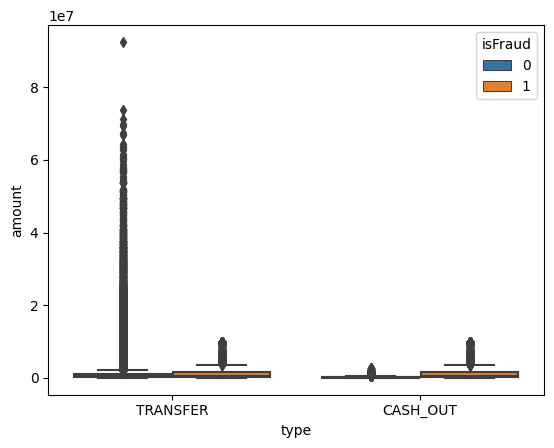

In [15]:
sns.boxplot(x='type',y='amount', hue = 'isFraud',data=df)


There are a lot of outliers in 'TRANSFER' but we cannot remove that data 
because many outliers are associated with Fraudulent transactions.<br>
it is very clear from here Fraud transaction comes out from 'TRANSFER' and 'CASH_OUT' type transaction.<br>
If I remove outliers than it is removing our fraudulent main data for which we have to apply prediction.<br>
So I am not removing outliers.
### Check multi-collinearity

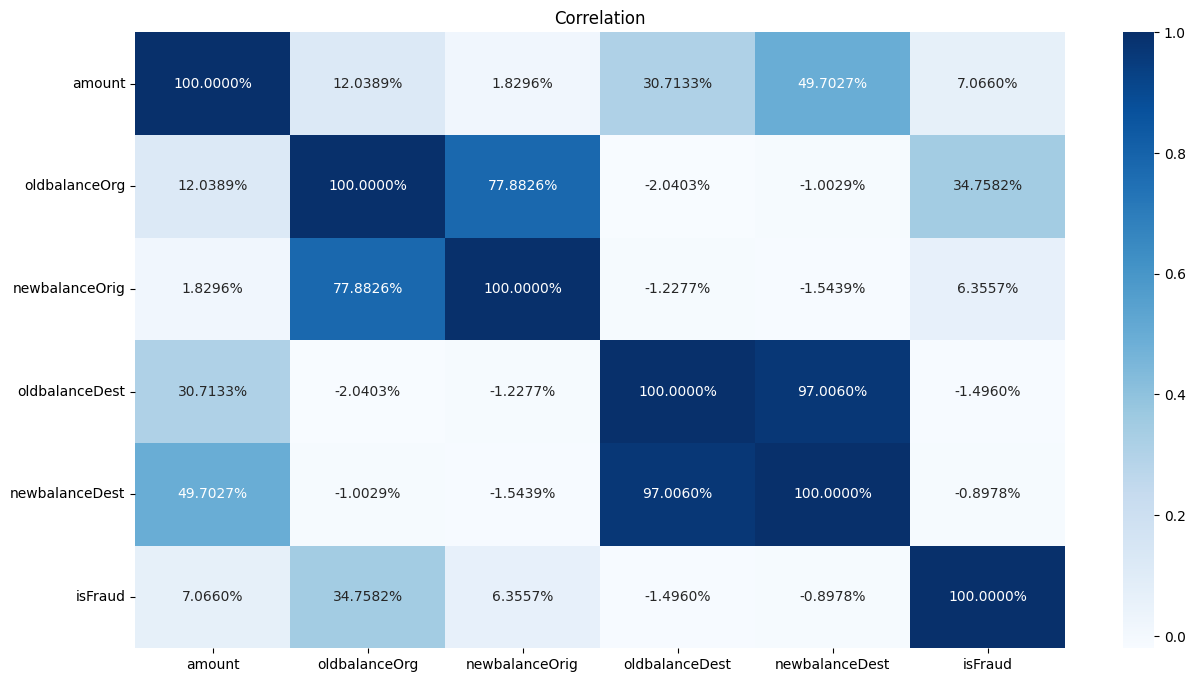

In [16]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(numeric_only= True), cmap='Blues',fmt='.4%', annot=True)
plt.title('Correlation')
plt.show()

From Correlation graph we can conclude:<br>
1. oldbalanceorg and new balanceorig are highly correlated, so both are multi-colinear<br>
2. oldbalanceDest and newbalanceDest are highly correlated, so both are multi-colinear<br>

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
col = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
df_vif = df[col]
df_vif

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,181.00,181.00,0.0,0.00,0.00
1,181.00,181.00,0.0,21182.00,0.00
2,229133.94,15325.00,0.0,5083.00,51513.44
3,215310.30,705.00,0.0,22425.00,0.00
4,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...
2770404,339682.13,339682.13,0.0,0.00,339682.13
2770405,6311409.28,6311409.28,0.0,0.00,0.00
2770406,6311409.28,6311409.28,0.0,68488.84,6379898.11
2770407,850002.52,850002.52,0.0,0.00,0.00


In [19]:
VIFDATA = pd.DataFrame()
VIFDATA["feature"] = df_vif.columns
VIFDATA["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
# [variance_inflation_factor(df_2.values, i)
#                           for i in range(len(df_2.columns))]
  
print(VIFDATA)

          feature        VIF
0          amount   5.052363
1   oldbalanceOrg   2.751613
2  newbalanceOrig   2.627088
3  oldbalanceDest  64.928278
4  newbalanceDest  80.568533


On the basis of VIF(too high) ,I will make a new column 'ActualbalanceDest' by removing 'oldbalanceDest' and 'newbalanceDest'.

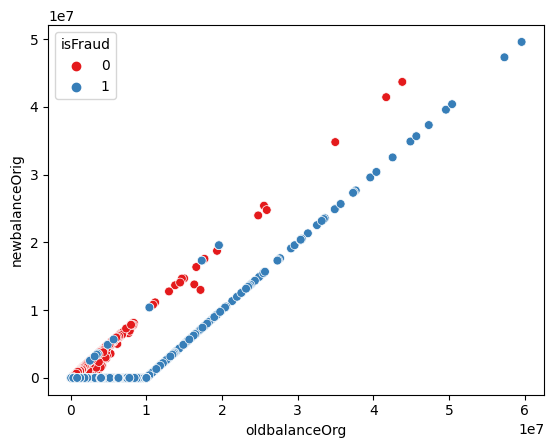

In [20]:
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', data=df, palette='Set1',s=40)
plt.xlabel('oldbalanceOrg')
plt.ylabel('newbalanceOrig')
plt.show()

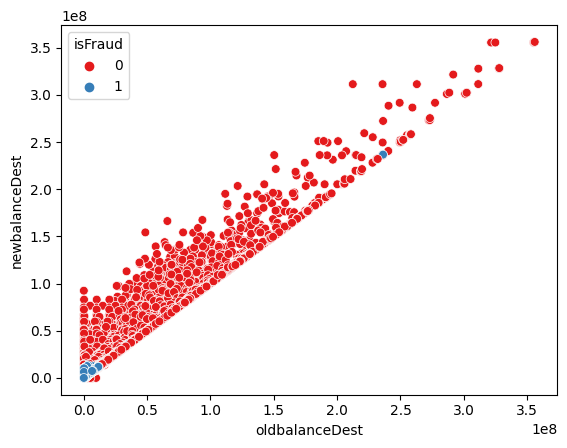

In [21]:
sns.scatterplot(x='oldbalanceDest', y='newbalanceDest', hue='isFraud', data=df, palette='Set1',s=40)
plt.xlabel('oldbalanceDest')
plt.ylabel('newbalanceDest')
plt.show()

8213
25000


<AxesSubplot: >

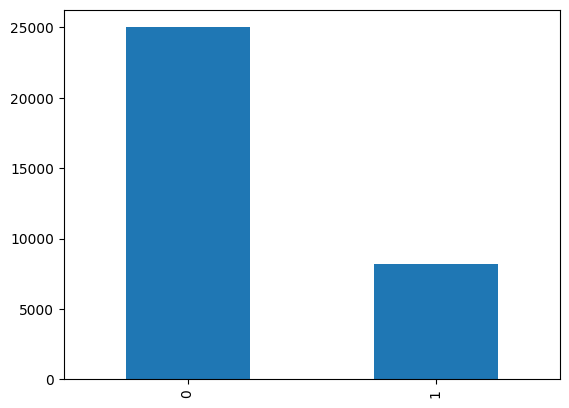

In [22]:
# Hyperparameter tuning will be difficult on full data and as the data is highly imbalanced, we will be sampling the highly frequent 
# class accordingly
# sample_df = df.sample(25000)
isfraud_df = df[df['isFraud']==1]
nofraud_df = df[df['isFraud']==0].sample(25000)
print(len(isfraud_df))
print(len(nofraud_df))
sample_df= pd.concat([isfraud_df,nofraud_df]).reset_index(drop=True)
sample_df['isFraud'].value_counts().plot(kind='bar')

In [23]:
sample_df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1
1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1
2,TRANSFER,2806.00,C1420196421,2806.0,0.00,C972765878,0.00,0.00,1
3,CASH_OUT,2806.00,C2101527076,2806.0,0.00,C1007251739,26202.00,0.00,1
4,TRANSFER,20128.00,C137533655,20128.0,0.00,C1848415041,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...
33208,CASH_OUT,5590.89,C1577977277,105813.0,100222.11,C1673419845,2192978.84,2198569.72,0
33209,CASH_OUT,148697.93,C1442035458,0.0,0.00,C970311059,218869.91,367567.85,0
33210,CASH_OUT,71428.47,C2115768125,158.0,0.00,C898408922,213233.90,284662.37,0
33211,CASH_OUT,11694.61,C1609582765,0.0,0.00,C1507636113,1264648.49,1276343.10,0


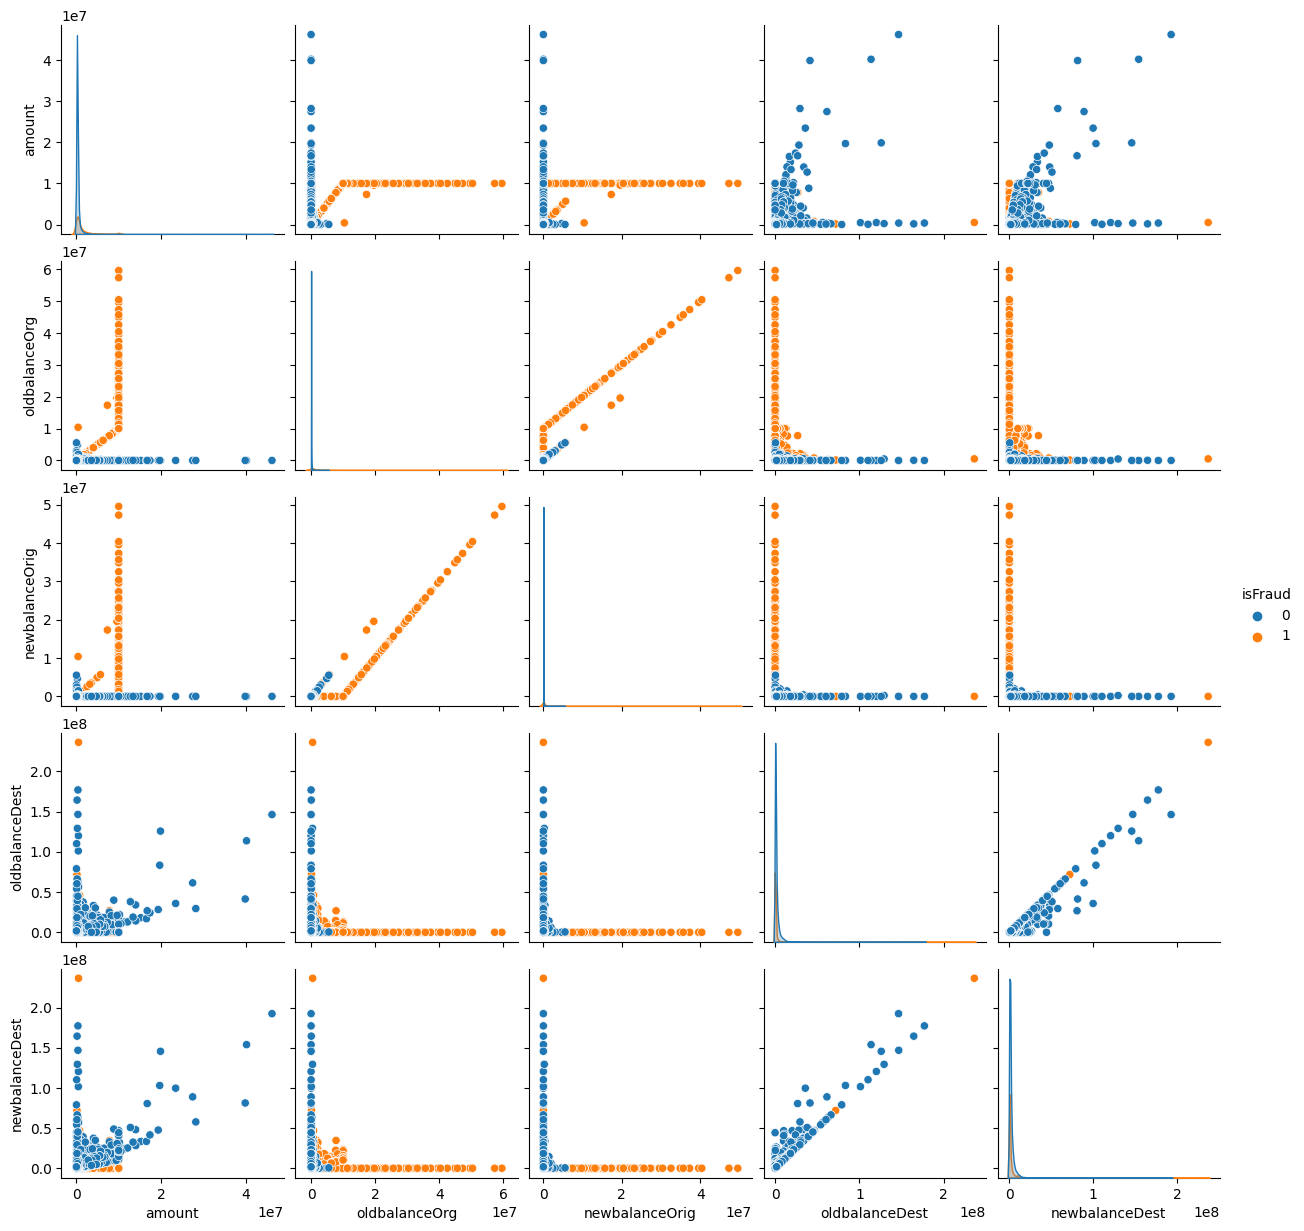

In [24]:
sns.pairplot(sample_df,vars = [ 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'],dropna = True, hue = 'isFraud')
plt.show()

In [25]:
sample_df['Actual_amount_dest'] = sample_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
sample_df = sample_df.drop(['oldbalanceDest','newbalanceDest'],axis = 1)
sample_df.head(2)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFraud,Actual_amount_dest
0,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,1,0.0
1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,1,21182.0


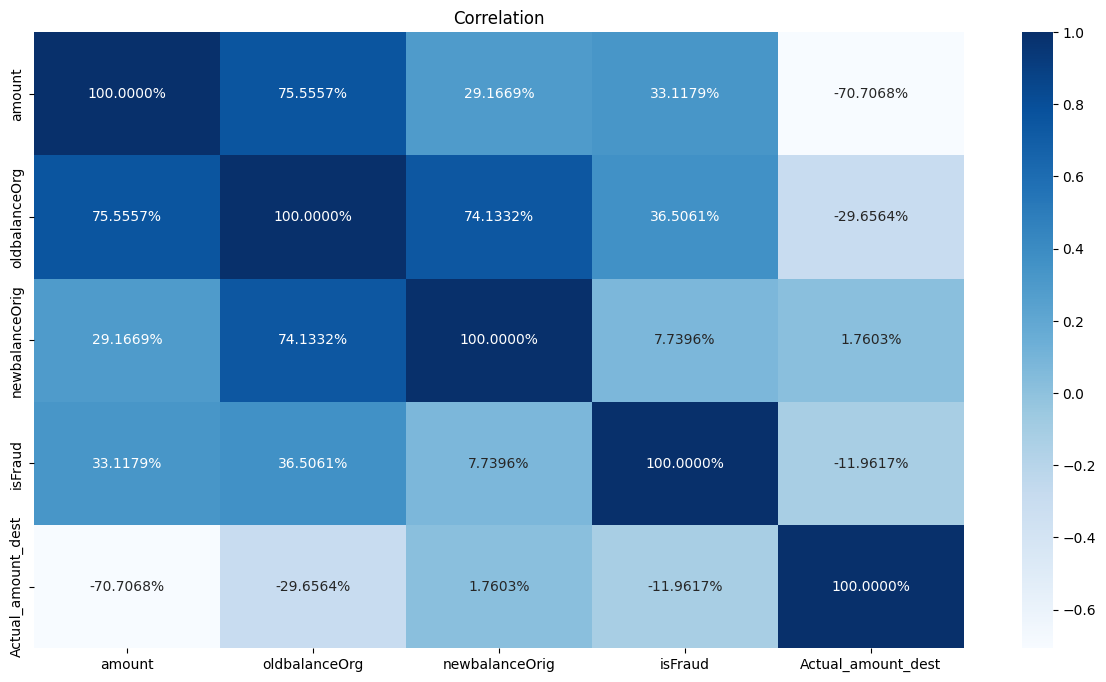

In [26]:
plt.figure(figsize=(15,8))
sns.heatmap(sample_df.corr(numeric_only= True), cmap='Blues',fmt='.4%', annot=True)
plt.title('Correlation')
plt.show()

**Since our 99.87 data is 0 so it is high imbalanced data**,<br>
in isFraud column model accuracy doesn't matter.

### Declaring the inputs and the targets

In [27]:
sample_df = pd.get_dummies(sample_df,columns = ['type'],drop_first = True,dtype=int)
sample_df

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFraud,Actual_amount_dest,type_TRANSFER
0,181.00,C1305486145,181.0,0.00,C553264065,1,0.00,1
1,181.00,C840083671,181.0,0.00,C38997010,1,21182.00,0
2,2806.00,C1420196421,2806.0,0.00,C972765878,1,0.00,1
3,2806.00,C2101527076,2806.0,0.00,C1007251739,1,26202.00,0
4,20128.00,C137533655,20128.0,0.00,C1848415041,1,0.00,1
...,...,...,...,...,...,...,...,...
33208,5590.89,C1577977277,105813.0,100222.11,C1673419845,0,-5590.88,0
33209,148697.93,C1442035458,0.0,0.00,C970311059,0,-148697.94,0
33210,71428.47,C2115768125,158.0,0.00,C898408922,0,-71428.47,0
33211,11694.61,C1609582765,0.0,0.00,C1507636113,0,-11694.61,0


In [28]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X =sample_df.drop(columns = ['isFraud','nameOrig','nameDest'],axis=1)
Y = sample_df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26570, 5) (6643, 5) (26570,) (6643,)


In [29]:
X_train.head()

,amount,oldbalanceOrg,newbalanceOrig,Actual_amount_dest,type_TRANSFER
17539,617684.54,0.0,0.0,-617684.54,1
21452,265819.11,182815.0,0.0,-265819.10,0
28260,44002.42,25790.3,0.0,-44002.42,0
31546,203817.46,0.0,0.0,-203817.45,0
31539,145859.53,0.0,0.0,-145859.53,0


In [30]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scaled_X_train_data = scale.fit_transform(X_train)

scaled_X_test_data = scale.transform(X_test)
scaled_X_train_data

array([[ 0.01273676, -0.22919114, -0.06111303, -0.12875911,  1.65105576],
       [-0.22429406, -0.13502057, -0.06111303,  0.12318418, -0.60567306],
       [-0.37371878, -0.21590619, -0.06111303,  0.28200973, -0.60567306],
       ...,
       [-0.11558077, -0.22124705, -0.06111303,  0.00763134, -0.60567306],
       [ 1.80900828,  1.4625453 , -0.06111303, -2.03804048, -0.60567306],
       [-0.34876907, -0.22919114, -0.06111303,  0.25549035, -0.60567306]])

In [31]:
scaled_X_train_data.shape

(26570, 5)

In [32]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [33]:
model = Sequential()
model.add(Dense(10,activation = 'relu',input_dim = 5))
model.add(Dense(10,activation = 'relu',input_dim = 5))
model.add(Dense(1,activation = 'sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(loss ='binary_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

In [36]:
history = model.fit(scaled_X_train_data,y_train,epochs =50,validation_split=0.2 )

Epoch 1/50
665/665 [==============================] - 3s 3ms/step - loss: 0.3913 - accuracy: 0.8430 - val_loss: 0.2917 - val_accuracy: 0.9244
Epoch 2/50
665/665 [==============================] - 2s 2ms/step - loss: 0.2566 - accuracy: 0.9254 - val_loss: 0.2209 - val_accuracy: 0.9385
Epoch 3/50
665/665 [==============================] - 2s 2ms/step - loss: 0.1953 - accuracy: 0.9357 - val_loss: 0.1721 - val_accuracy: 0.9445
Epoch 4/50
665/665 [==============================] - 2s 2ms/step - loss: 0.1657 - accuracy: 0.9407 - val_loss: 0.1529 - val_accuracy: 0.9449
Epoch 5/50
665/665 [==============================] - 2s 2ms/step - loss: 0.1487 - accuracy: 0.9440 - val_loss: 0.1397 - val_accuracy: 0.9484
Epoch 6/50
665/665 [==============================] - 2s 3ms/step - loss: 0.1377 - accuracy: 0.9484 - val_loss: 0.1321 - val_accuracy: 0.9511
Epoch 7/50
665/665 [==============================] - 2s 3ms/step - loss: 0.1306 - accuracy: 0.9510 - val_loss: 0.1254 - val_accuracy: 0.9535
Epoch 

In [37]:
model.layers[1].get_weights()

[array([[-1.5841041e+00, -2.6964611e-01, -2.7202988e-01, -4.1175386e-01,
         -1.8777779e-01, -6.8439537e-01,  6.4532268e-01, -1.5761843e-01,
         -1.8600418e-01, -5.4778844e-01],
        [-6.1937886e-01,  1.9032532e-01,  1.9264042e-01,  5.6351453e-01,
          1.1799177e-01, -3.6071423e-01,  6.9104487e-01, -4.6572428e-02,
          3.0485019e-01, -2.8759739e-01],
        [ 7.8401208e-01,  1.0265518e+00,  8.9557362e-01,  8.5484511e-01,
         -2.4521804e+00, -2.8129295e-01, -2.1134565e+00, -2.6198173e+00,
         -6.3572758e-01,  3.8076463e-01],
        [ 1.2819028e+00, -2.0910561e+00, -7.5743961e+00, -5.2902875e+00,
          8.4439439e-01,  1.5227766e-01, -3.4782752e-01,  4.8231766e-01,
          3.7294157e-02, -1.5060481e-02],
        [ 7.5214976e-01, -2.0784171e-01,  6.9076157e-01,  3.3396289e-02,
         -8.3025062e-01,  2.2020221e-01, -1.2203375e+00, -2.8634360e-01,
         -2.4637088e-02, -2.0099191e-01],
        [ 4.4536117e-01, -2.2006568e-02, -2.5888199e-01, -5.

In [38]:
y_thre = model.predict(scaled_X_test_data)

208/208 [==============================] - 0s 2ms/step


In [39]:
y_pre = np.where(y_thre > .5,1,0)

In [40]:
y_pre

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pre)

0.9799789251844047

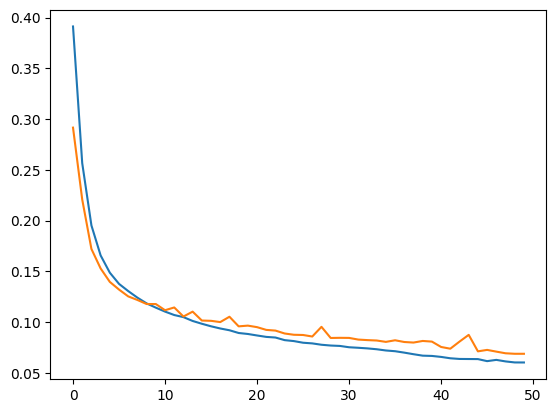

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

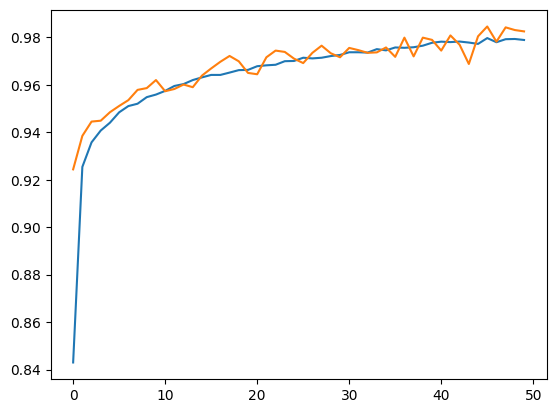

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [44]:
sample_df

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFraud,Actual_amount_dest,type_TRANSFER
0,181.00,C1305486145,181.0,0.00,C553264065,1,0.00,1
1,181.00,C840083671,181.0,0.00,C38997010,1,21182.00,0
2,2806.00,C1420196421,2806.0,0.00,C972765878,1,0.00,1
3,2806.00,C2101527076,2806.0,0.00,C1007251739,1,26202.00,0
4,20128.00,C137533655,20128.0,0.00,C1848415041,1,0.00,1
...,...,...,...,...,...,...,...,...
33208,5590.89,C1577977277,105813.0,100222.11,C1673419845,0,-5590.88,0
33209,148697.93,C1442035458,0.0,0.00,C970311059,0,-148697.94,0
33210,71428.47,C2115768125,158.0,0.00,C898408922,0,-71428.47,0
33211,11694.61,C1609582765,0.0,0.00,C1507636113,0,-11694.61,0


In [45]:
def predict_mpg(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    
    y_thre = model.predict(df)
    y_pred = np.where(y_thre > .5,1,0)
    
    
    if y_pred == 0:
        return 'Not a Fraud'
    elif y_pred == 1:
        return 'absolutely Fraud'

In [46]:
config = {
    'amount': [ 131114.18],
    'oldbalanceOrg': [0.0],
    'newbalanceOrig': [0.0],
    'Actual_amount_dest':[-131114.18],
    'type_TRANSFER':[0] # 1 is for TRANSFER, 0 is for CASH_OUT
}

predict_mpg(config, model)

1/1 [==============================] - 0s 83ms/step


'Not a Fraud'

In [47]:
import pickle

# Save to file in the current working directory
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# Calculate the accuracy score and predict target values
score = accuracy_score(y_test,y_pre)
print("Test score: {0:.2f} %".format(100 * score))
y_thre = pickle_model.predict(scaled_X_test_data)
y_pred = np.where(y_thre > .5,1,0)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-06-05 15:00:07         1853
variables.h5                                   2024-06-05 15:00:07        27136
metadata.json                                  2024-06-05 15:00:07           64
Keras model archive loading:
File Name                                             Modified         

In [48]:
##loading the model from the saved file
pkl_filename = "model.pkl"
with open(pkl_filename, 'rb') as f_in:
    model = pickle.load(f_in)

predictValue = predict_mpg(config, model)
predictValue

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-06-05 15:00:06         1853
variables.h5                                   2024-06-05 15:00:06        27136
metadata.json                                  2024-06-05 15:00:06           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
1/1 [==============================] - 0s 79ms/step


'Not a Fraud'

## Train Test Split
Split the variables with an 80-20 split and some random state

## Standardization

## Evaluation metric
## Model Building (With Hyperparameter Tuning)
### Logistic Regression
f1 score,precision_score, recall_score

## Accuracy

## Confusion Matrix

## Random Forest Hyperparameter tuning

## XgBoost Classifier

## select variables to be included in the model
##  feature importance

### Random Forest

### XGBoost

From the graph of the most important features within the model, we can observe some key points:
Most important features are "newBalanceOrig" and "oldBalanceOrg", we can infer this from random-forest and XGBoost, as both of the model are ranking these features as very important.

## Conclusion
Here best F1 Score for both XGBoost and Random Forest is very high, so both models are pretty good at what they do.

In a fraud detection model, F1 score is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly. Because of highly imbalanced data we may catch the innocent and leave the culprit.
The reason why F1 Score is being used instead of accuracy, because accuracy cannot handle imbalance in the data.

Answers to the Questions

1. Data cleaning including missing values, outliers and multi-collinearity.

    Since there were no missing values in the dataset, I did not need to perform any data cleaning related to that. I checked for multicollinearity using correlation analysis.If I remove outliers than it is removing our fraudulent main data for which we have to apply prediction.



2. Describe your fraud detection model in elaboration.
* This fraud detection model is based on Logistic Regression, Random Forest algorithm and XGBoost as it's a large dataset with a imbalance data. Random Forest is an ensemble learning method that combines multiple decision trees to make a final prediction.Each decision tree is trained on a different subset of the data and a different set of features. When making a prediction, the final prediction is made by averaging the predictions of all the decision trees.<br>
XGBoost is an implementation of gradient-boosting decision trees. that's why it is an ideal choice for an imbalance dataset.XgBoost is a gradient boosting algorithm for supervised learning. It's a highly efficient and scalable implementation of the boosting algorithm, with performance comparable to that of other state-of-the-art machine learning algorithms in most cases. 

3. How did you select variables to be included in the model?
* I selected variables to be included in the model based on domain knowledge and feature importance analysis.

4. Demonstrate the performance of the model by using best set of tools.
* I evaluated the performance of the model using several metrics such as accuracy, precision, recall, F1 score. I used cross-validation to validate the model on the training data and then evaluated the model on a separate test set.

5. What are the key factors that predict fraudulent customer?
* The key factors that predict fraudulent customers include transaction amount, transaction type, if flagged as fraud of the transaction. Other important factors can consider feature importance analysis. 

6. Do these factors make sense? If yes, How? If not, How not?
* These factors make sense because they are consistent with known patterns of fraudulent activity. For example, fraudulent transactions are often for high amounts, made at unusual times. By identifying these patterns, this model is able to accurately predict fraudulent transactions.

7. What kind of prevention should be adopted while company update its infrastructure?
* To prevent fraud, companies can adopt several prevention measures such as implementing multifactorial authentication, monitoring transactions in real-time, and implementing machine learning models to detect and flag suspicious transactions. It is also important to regularly update security protocols and educate employees and customers about fraud prevention best practices.

8. Assuming these actions have been implemented, how would you determine if they work?

    I would determine the effectiveness of the prevention measures by monitoring the number of flagged transactions and the number of false positives generated by the model. I would also evaluate the cost and efficiency of implementing the prevention measures to ensure that they are effective and feasible for the company.
